### 데이터 읽기

In [2]:
import pandas as pd

# CSV 파일 경로 지정
call119_path = './call119_train.csv'
cat119_path = './cat119_train.csv'
solar_path = './solar_data.csv'

# CSV 파일 읽기
call119_df = pd.read_csv(call119_path)
cat119_df = pd.read_csv(cat119_path)
solar_df = pd.read_csv(solar_path, encoding='cp949')

In [3]:
# 데이터 확인
print("call119_train.csv")
call119_df.head(10)

call119_train.csv


,Unnamed: 0,call119_train.tm,call119_train.address_city,call119_train.address_gu,call119_train.sub_address,call119_train.stn,call119_train.ta_max,call119_train.ta_min,call119_train.ta_max_min,call119_train.hm_min,call119_train.hm_max,call119_train.ws_max,call119_train.ws_ins_max,call119_train.rn_day,call119_train.call_count
0,1,20200501,부산광역시,강서구,대저2동,904,23.7,16.6,7.1,63.2,90.3,5.8,10.6,0.0,1
1,2,20200501,부산광역시,강서구,천성동,921,24.3,15.4,8.9,64.2,96.4,4.8,8.6,0.0,1
2,3,20200501,부산광역시,금정구,금사동,940,25.6,17.2,8.4,46.6,76.4,4.8,8.3,0.0,1
3,4,20200501,부산광역시,금정구,금성동,941,25.3,17.1,8.2,-99.0,-99.0,7.1,9.7,0.0,1
4,5,20200501,부산광역시,금정구,남산동,939,26.5,16.7,9.8,-99.0,-99.0,5.7,8.1,0.0,3
5,6,20200501,부산광역시,금정구,부곡동,940,25.6,17.2,8.4,46.6,76.4,4.8,8.3,0.0,1
6,7,20200501,부산광역시,금정구,장전동,940,25.6,17.2,8.4,46.6,76.4,4.8,8.3,0.0,1
7,8,20200501,부산광역시,기장군,기장읍,923,26.9,15.9,11.0,49.7,87.6,4.2,7.3,0.0,1
8,9,20200501,부산광역시,기장군,일광면,923,26.9,15.9,11.0,49.7,87.6,4.2,7.3,0.0,2
9,10,20200501,부산광역시,기장군,장안읍,923,26.9,15.9,11.0,49.7,87.6,4.2,7.3,0.0,1


In [4]:
print("cat119_train.csv")
cat119_df.head(10)

cat119_train.csv


,Unnamed: 0,cat119_train.tm,cat119_train.address_city,cat119_train.address_gu,cat119_train.sub_address,cat119_train.cat,cat119_train.sub_cat,cat119_train.stn,cat119_train.call_count
0,1,20200501,부산광역시,강서구,대저2동,구급,교통사고,904,1
1,2,20200501,부산광역시,강서구,천성동,구조,교통사고,921,1
2,3,20200501,부산광역시,금정구,금사동,구급,부상,940,1
3,4,20200501,부산광역시,금정구,금성동,기타,업무운행,941,1
4,5,20200501,부산광역시,금정구,남산동,구급,부상,939,1
5,6,20200501,부산광역시,금정구,남산동,기타,업무운행,939,2
6,7,20200501,부산광역시,금정구,부곡동,구급,부상,940,1
7,8,20200501,부산광역시,금정구,장전동,구급,교통사고,940,1
8,9,20200501,부산광역시,기장군,기장읍,구급,교통사고,923,1
9,10,20200501,부산광역시,기장군,일광면,구급,부상,923,1


In [5]:
print("cat119_train.csv")
solar_df.head(10)

cat119_train.csv


,지점,일시,가조시간(hr),합계 일조시간(hr),1시간 최다일사 시각(hhmi),1시간 최다일사량(MJ/m2),합계 일사량(MJ/m2)
0,159,2020-05-01,13.6,11.6,1200.0,3.54,26.87
1,159,2020-05-02,13.6,5.0,1000.0,2.82,17.20
2,159,2020-05-03,13.7,0.0,1200.0,0.49,3.05
3,159,2020-05-04,13.7,9.7,1200.0,3.44,24.98
4,159,2020-05-05,13.7,1.9,900.0,2.29,15.24
5,159,2020-05-06,13.8,12.3,1200.0,3.61,28.54
6,159,2020-05-07,13.8,12.2,1100.0,3.67,29.25
7,159,2020-05-08,13.8,7.2,1000.0,3.22,23.22
8,159,2020-05-09,13.9,0.0,1200.0,0.37,2.08
9,159,2020-05-10,13.9,6.1,1400.0,2.75,20.27


In [6]:
call119_df.tail()

,Unnamed: 0,call119_train.tm,call119_train.address_city,call119_train.address_gu,call119_train.sub_address,call119_train.stn,call119_train.ta_max,call119_train.ta_min,call119_train.ta_max_min,call119_train.hm_min,call119_train.hm_max,call119_train.ws_max,call119_train.ws_ins_max,call119_train.rn_day,call119_train.call_count
42919,42920,20231031,부산광역시,해운대구,반송동,937,26.3,8.8,17.5,20.2,97.4,4.6,8.4,0.0,2
42920,42921,20231031,부산광역시,해운대구,반여동,937,26.3,8.8,17.5,20.2,97.4,4.6,8.4,0.0,2
42921,42922,20231031,부산광역시,해운대구,석대동,940,24.5,10.0,14.5,20.4,94.0,2.4,6.1,0.0,1
42922,42923,20231031,부산광역시,해운대구,송정동,937,26.3,8.8,17.5,20.2,97.4,4.6,8.4,0.0,1
42923,42924,20231031,부산광역시,해운대구,재송동,937,26.3,8.8,17.5,20.2,97.4,4.6,8.4,0.0,1


In [7]:
cat119_df.tail()

,Unnamed: 0,cat119_train.tm,cat119_train.address_city,cat119_train.address_gu,cat119_train.sub_address,cat119_train.cat,cat119_train.sub_cat,cat119_train.stn,cat119_train.call_count
61766,61767,20231031,부산광역시,해운대구,반여동,구급,교통사고,937,1
61767,61768,20231031,부산광역시,해운대구,반여동,구급,부상,937,1
61768,61769,20231031,부산광역시,해운대구,석대동,구급,부상,940,1
61769,61770,20231031,부산광역시,해운대구,송정동,기타,업무운행,937,1
61770,61771,20231031,부산광역시,해운대구,재송동,구급,부상,937,1


In [8]:
solar_df.tail()

,지점,일시,가조시간(hr),합계 일조시간(hr),1시간 최다일사 시각(hhmi),1시간 최다일사량(MJ/m2),합계 일사량(MJ/m2)
731,159,2023-10-27,10.9,8.3,1200.0,2.52,14.73
732,159,2023-10-28,10.9,9.6,1200.0,2.48,16.19
733,159,2023-10-29,10.9,9.8,1200.0,2.80,17.16
734,159,2023-10-30,10.8,9.9,1100.0,2.43,15.49
735,159,2023-10-31,10.8,10.0,1200.0,2.51,16.06


In [9]:
# Info
call119_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42924 entries, 0 to 42923
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  42924 non-null  int64  
 1   call119_train.tm            42924 non-null  int64  
 2   call119_train.address_city  42924 non-null  object 
 3   call119_train.address_gu    42924 non-null  object 
 4   call119_train.sub_address   42924 non-null  object 
 5   call119_train.stn           42924 non-null  int64  
 6   call119_train.ta_max        42924 non-null  float64
 7   call119_train.ta_min        42924 non-null  float64
 8   call119_train.ta_max_min    42924 non-null  float64
 9   call119_train.hm_min        42924 non-null  float64
 10  call119_train.hm_max        42924 non-null  float64
 11  call119_train.ws_max        42924 non-null  float64
 12  call119_train.ws_ins_max    42924 non-null  float64
 13  call119_train.rn_day        429

In [10]:
cat119_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61771 entries, 0 to 61770
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Unnamed: 0                 61771 non-null  int64 
 1   cat119_train.tm            61771 non-null  int64 
 2   cat119_train.address_city  61771 non-null  object
 3   cat119_train.address_gu    61771 non-null  object
 4   cat119_train.sub_address   61771 non-null  object
 5   cat119_train.cat           61771 non-null  object
 6   cat119_train.sub_cat       61771 non-null  object
 7   cat119_train.stn           61771 non-null  int64 
 8   cat119_train.call_count    61771 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 4.2+ MB


In [11]:
solar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   지점                 736 non-null    int64  
 1   일시                 736 non-null    object 
 2   가조시간(hr)           736 non-null    float64
 3   합계 일조시간(hr)        734 non-null    float64
 4   1시간 최다일사 시각(hhmi)  734 non-null    float64
 5   1시간 최다일사량(MJ/m2)   734 non-null    float64
 6   합계 일사량(MJ/m2)      734 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 40.4+ KB


In [12]:
# Describe
call119_df.describe()

,Unnamed: 0,call119_train.tm,call119_train.stn,call119_train.ta_max,call119_train.ta_min,call119_train.ta_max_min,call119_train.hm_min,call119_train.hm_max,call119_train.ws_max,call119_train.ws_ins_max,call119_train.rn_day,call119_train.call_count
count,42924.000000,4.292400e+04,42924.000000,42924.000000,42924.000000,42924.000000,42924.000000,42924.000000,42924.000000,42924.000000,42924.000000,42924.000000
mean,21462.500000,2.021586e+07,816.492126,26.025443,18.431968,7.286723,45.600601,76.598558,4.422377,8.185700,8.280265,1.916760
std,12391.235814,1.100894e+04,278.509107,8.059514,8.093267,6.623270,43.425352,49.403930,6.343533,7.183937,27.216865,2.058855
min,1.000000,2.020050e+07,159.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,1.000000
25%,10731.750000,2.021051e+07,904.000000,23.600000,15.500000,5.500000,40.200000,83.300000,3.400000,6.100000,0.000000,1.000000
50%,21462.500000,2.021103e+07,938.000000,26.600000,19.500000,7.500000,56.500000,91.800000,4.200000,7.700000,0.000000,1.000000
75%,32193.250000,2.022103e+07,940.000000,29.400000,22.500000,9.600000,67.700000,96.700000,5.500000,9.900000,2.000000,2.000000
max,42924.000000,2.023103e+07,950.000000,37.600000,29.000000,23.000000,99.500000,100.000000,30.700000,37.800000,259.200000,115.000000


In [13]:
cat119_df.describe()

,Unnamed: 0,cat119_train.tm,cat119_train.stn,cat119_train.call_count
count,61771.000000,6.177100e+04,61771.000000,61771.000000
mean,30886.000000,2.021578e+07,835.680934,1.331936
std,17831.896076,1.086659e+04,259.170544,1.288823
min,1.000000,2.020050e+07,159.000000,1.000000
25%,15443.500000,2.021052e+07,923.000000,1.000000
50%,30886.000000,2.021102e+07,938.000000,1.000000
75%,46328.500000,2.022102e+07,941.000000,1.000000
max,61771.000000,2.023103e+07,950.000000,72.000000


In [14]:
solar_df.describe()

,지점,가조시간(hr),합계 일조시간(hr),1시간 최다일사 시각(hhmi),1시간 최다일사량(MJ/m2),합계 일사량(MJ/m2)
count,736.0,736.000000,734.000000,734.000000,734.000000,734.000000
mean,159.0,13.319022,6.112262,1190.054496,2.611376,17.610136
std,0.0,1.155003,4.308086,122.376412,0.943699,7.990756
min,159.0,10.800000,0.000000,800.000000,0.210000,1.290000
25%,159.0,12.400000,1.800000,1100.000000,2.095000,12.045000
50%,159.0,13.800000,6.800000,1200.000000,2.860000,18.360000
75%,159.0,14.300000,10.100000,1200.000000,3.380000,24.635000
max,159.0,14.500000,12.600000,1600.000000,3.870000,30.730000


### 데이터 병합 

In [15]:
# 날짜 전처리 및 통일
call119_df['tm'] = pd.to_datetime(call119_df['call119_train.tm'], format='%Y%m%d')
cat119_df['tm'] = pd.to_datetime(cat119_df['cat119_train.tm'], format='%Y%m%d')
solar_df['일시'] = pd.to_datetime(solar_df['일시'])

In [16]:
# 지역명 정리
call119_df['city'] = call119_df['call119_train.address_city'].str.replace('광역시|특별시|도', '', regex=True)
solar_df['city'] = '부산'  # solar 데이터 기준이 부산이라면 고정

In [17]:
merged = pd.merge(call119_df, solar_df, left_on=['tm', 'city'], right_on=['일시', 'city'], how='left')

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

In [ ]:
import matplotlib.font_manager as fm
# 예: 맑은 고딕 폰트 사용
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
# plt.rcParams['font.family'] = 'AppleGothic'  # macOS
# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [19]:
# 파생 변수 생성 (WBGT + 일조율)
def compute_wbgt(Ta, RH, SR):
    Tw = Ta * np.arctan(0.151977 * np.sqrt(RH + 8.313659)) + \
         np.arctan(Ta + RH) - np.arctan(RH - 1.676331) + \
         0.00391838 * (RH**1.5) * np.arctan(0.023101 * RH) - 4.686035
    Tg = Ta + 0.2 * (SR / 10)
    WBGT = 0.7 * Tw + 0.2 * Tg + 0.1 * Ta
    return WBGT

merged['WBGT'] = compute_wbgt(
    Ta=merged['call119_train.ta_max'],
    RH=merged['call119_train.hm_max'],
    SR=merged['합계 일사량(MJ/m2)']
)

merged['일조율'] = merged['합계 일조시간(hr)'] / merged['가조시간(hr)']
merged['일교차'] = merged['call119_train.ta_max'] - merged['call119_train.ta_min']
merged['tm_weekday'] = merged['tm'].dt.weekday
merged['tm_month'] = merged['tm'].dt.month

c:\Users\asia\.conda\envs\py312tf2\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


c:\Users\asia\.conda\envs\py312tf2\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\asia\.conda\envs\py312tf2\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\asia\.conda\envs\py312tf2\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\asia\.conda\envs\py312tf2\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\asia\.conda\envs\py312tf2\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font

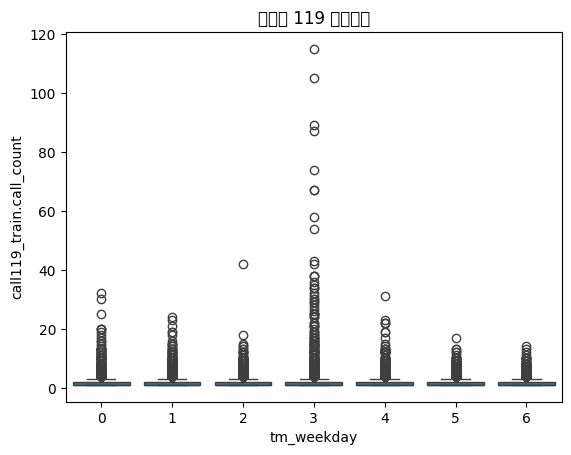

c:\Users\asia\.conda\envs\py312tf2\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\asia\.conda\envs\py312tf2\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\asia\.conda\envs\py312tf2\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\asia\.conda\envs\py312tf2\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


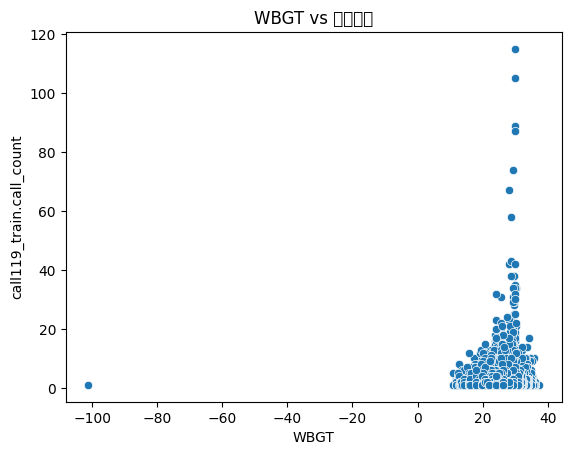

In [20]:
# EDA 시각화 예시
sns.boxplot(data=merged, x='tm_weekday', y='call119_train.call_count')
plt.title('요일별 119 신고건수')
plt.show()

sns.scatterplot(data=merged, x='WBGT', y='call119_train.call_count')
plt.title('WBGT vs 신고건수')
plt.show()

In [21]:
# 신고 유형별 집계
cat_grouped = cat119_df.groupby(['tm', 'cat119_train.cat'])['cat119_train.call_count'].sum().reset_index()
cat_grouped = cat_grouped.pivot(index='tm', columns='cat119_train.cat', values='cat119_train.call_count').fillna(0).reset_index()
cat_grouped.head()


cat119_train.cat,tm,구급,구조,기타,화재
0,2020-05-01,66.0,5.0,17.0,1.0
1,2020-05-02,64.0,8.0,9.0,0.0
2,2020-05-03,58.0,9.0,7.0,0.0
3,2020-05-04,68.0,12.0,17.0,0.0
4,2020-05-05,52.0,8.0,10.0,0.0


In [22]:
# 날짜 기준 병합
final = pd.merge(merged, cat_grouped, left_on='tm', right_on='tm', how='left')
final.head()

,Unnamed: 0,call119_train.tm,call119_train.address_city,call119_train.address_gu,call119_train.sub_address,call119_train.stn,call119_train.ta_max,call119_train.ta_min,call119_train.ta_max_min,call119_train.hm_min,...,합계 일사량(MJ/m2),WBGT,일조율,일교차,tm_weekday,tm_month,구급,구조,기타,화재
0,1,20200501,부산광역시,강서구,대저2동,904,23.7,16.6,7.1,63.2,...,26.87,22.935266,0.852941,7.1,4,5,66.0,5.0,17.0,1.0
1,2,20200501,부산광역시,강서구,천성동,921,24.3,15.4,8.9,64.2,...,26.87,24.099974,0.852941,8.9,4,5,66.0,5.0,17.0,1.0
2,3,20200501,부산광역시,금정구,금사동,940,25.6,17.2,8.4,46.6,...,26.87,23.469217,0.852941,8.4,4,5,66.0,5.0,17.0,1.0
3,4,20200501,부산광역시,금정구,금성동,941,25.3,17.1,8.2,-99.0,...,26.87,NaN,0.852941,8.2,4,5,66.0,5.0,17.0,1.0
4,5,20200501,부산광역시,금정구,남산동,939,26.5,16.7,9.8,-99.0,...,26.87,NaN,0.852941,9.8,4,5,66.0,5.0,17.0,1.0


In [23]:
# 모델 학습
features = [
    'call119_train.ta_max', 'call119_train.ta_min', '일교차',
    'call119_train.hm_max', 'call119_train.hm_min',
    'call119_train.ws_max', 'call119_train.ws_ins_max',
    'call119_train.rn_day', '합계 일사량(MJ/m2)', '합계 일조시간(hr)',
    '가조시간(hr)', '일조율', 'WBGT', 'tm_weekday', 'tm_month'
]


In [24]:
# 타겟: '구급' 신고 예측 (예: 폭염 관련성 높음)
y = final['구급']
X = final[features].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

pred = model.predict(X_test)

# RMSE 직접 계산
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print("✅ RMSE (구급 신고 예측):", rmse)

✅ RMSE (구급 신고 예측): 1.1274535530429064


In [25]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, pred)
print("📈 R² score:", r2)

📈 R² score: 0.9955618918125457


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 기본 지표들
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

# 상대 지표들
mean_actual = np.mean(y_test)
max_actual = np.max(y_test)
min_actual = np.min(y_test)

# 상대적 오차 비율 (백분율)
rmse_pct_mean = (rmse / mean_actual) * 100
mae_pct_mean = (mae / mean_actual) * 100

print("📊 평가 지표 요약")
print(f"✅ RMSE: {rmse:.3f}")
print(f"✅ MAE: {mae:.3f}")
print(f"📈 R² score: {r2:.4f}")
print()
print(f"📌 평균 실제값: {mean_actual:.3f}")
print(f"📌 최대 실제값: {max_actual}")
print()
print(f"📉 RMSE / 평균값: {rmse_pct_mean:.2f}%")
print(f"📉 MAE / 평균값: {mae_pct_mean:.2f}%")

📊 평가 지표 요약
✅ RMSE: 1.127
✅ MAE: 0.169
📈 R² score: 0.9956

📌 평균 실제값: 79.017
📌 최대 실제값: 146.0

📉 RMSE / 평균값: 1.43%
📉 MAE / 평균값: 0.21%


In [27]:
#MAE가 지나치게 작고, RMSE는 상대적으로 크다 → 분산이 큰 몇 개의 극단값(outlier) 때문에 RMSE가 영향을 크게 받은 것일 수 있음


In [28]:
import matplotlib.font_manager as fm
# 예: 맑은 고딕 폰트 사용
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
# plt.rcParams['font.family'] = 'AppleGothic'  # macOS
# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

c:\Users\asia\.conda\envs\py312tf2\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


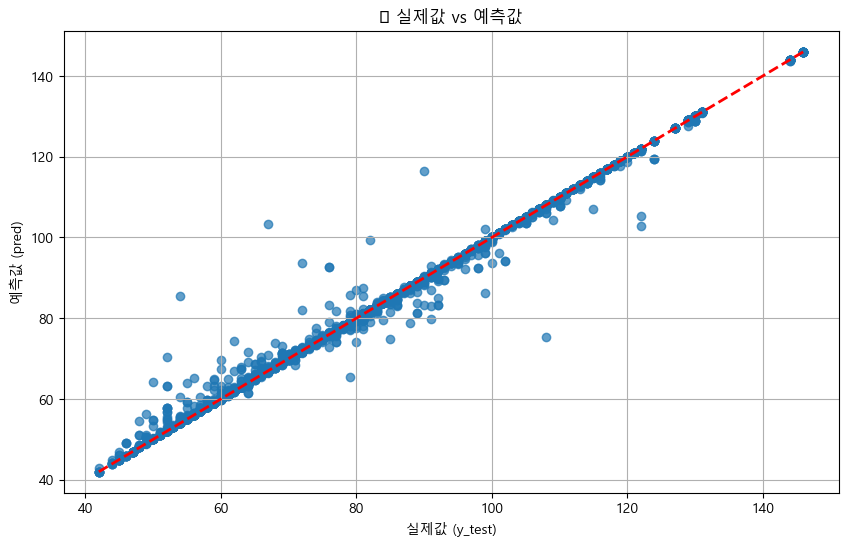

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('실제값 (y_test)')
plt.ylabel('예측값 (pred)')
plt.title('📈 실제값 vs 예측값')
plt.grid(True)
plt.show()

In [30]:
# 이상치(극단값)는 거의 없음 → 좋은 모델입니다.

# RMSE와 MAE의 차이는 자연스러운 현상이며, 예측이 어려운 일부 사례가 RMSE에 조금 더 영향을 준 정도입니다.

# R² = 0.9956, RMSE / 평균 = 1.43% → 실제로는 매우 안정적이고 정확한 모델이므로 걱정할 필요는 전혀 없습니다.